In [1]:
import itertools
import json

import pandas as pd
import numpy as np
import simpy
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from datetime import timedelta

In [2]:
with open("data/ger_ci.csv", "r") as f:
    ger = pd.read_csv(f, index_col=0, parse_dates=True)["Carbon Intensity"].rename("Germany")
ger['2020-06-01 00:00:00':]

Time
2020-06-01 00:00:00    170.319207
2020-06-01 00:15:00    171.376437
2020-06-01 00:30:00    173.543319
2020-06-01 00:45:00    175.554316
2020-06-01 01:00:00    175.636264
                          ...    
2021-01-09 22:00:00    521.153048
2021-01-09 22:15:00    517.600964
2021-01-09 22:30:00    514.656596
2021-01-09 22:45:00    510.659998
2021-01-09 23:00:00    508.090652
Name: Germany, Length: 21403, dtype: float64

<AxesSubplot: xlabel='time', ylabel='power'>

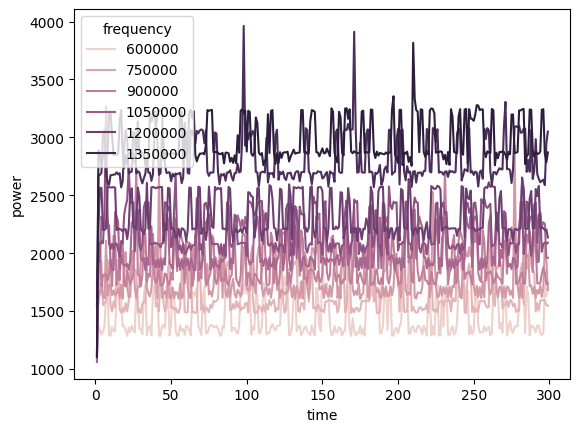

In [3]:
dfs = []
for freq in [600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]:
    with open(f"example_node/stress_test/data/{freq}.csv", "r") as f:
        dfs.append(pd.read_csv(f))
perf = pd.concat(dfs)
sns.lineplot(data=perf, x="time", y="power", hue="frequency")

In [4]:
p = perf.groupby("frequency").mean()["power"]
p.index /= 1000
p

frequency
600.0     1453.779866
700.0     1654.780903
800.0     1781.070569
900.0     1900.280368
1000.0    2044.742742
1100.0    2193.650167
1200.0    2321.230602
1300.0    2791.271773
1400.0    2964.385886
Name: power, dtype: float64

In [23]:
with open(f"example_node/stress_test/data/events_per_second.json", "r") as f:
    events_per_second = json.load(f)
events_per_second = pd.Series(events_per_second)
events_per_second.index = events_per_second.index.astype(float)
events_per_second.name = "events"
events_per_second

600.0     1192.27
700.0     1391.94
800.0     1592.71
900.0     1786.62
1000.0    1992.70
1100.0    2192.85
1200.0    2392.55
1300.0    2592.28
1400.0    2793.28
Name: events, dtype: float64

In [24]:
raspi = pd.concat([p, events_per_second], axis=1)
raspi

,power,events
600.0,1453.779866,1192.27
700.0,1654.780903,1391.94
800.0,1781.070569,1592.71
900.0,1900.280368,1786.62
1000.0,2044.742742,1992.70
1100.0,2193.650167,2192.85
1200.0,2321.230602,2392.55
1300.0,2791.271773,2592.28
1400.0,2964.385886,2793.28


(0.0, 2800.0)

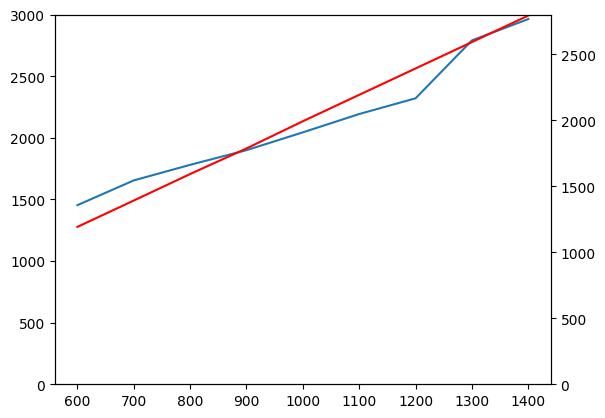

In [27]:
f, ax = plt.subplots()
raspi["power"].plot(ax=ax)
ax.set_ylim(0,3000)
ax2 = ax.twinx()
raspi["events"].plot(ax=ax2, color="red")
ax2.set_ylim(0,2800)

In [9]:
with open("data/weather_berlin_2021-06.csv", "r") as f:
    solar = pd.read_csv(f, index_col=0, parse_dates=True)["solar"]
solar.index = solar.index - timedelta(days=365)

# Simulation

In [10]:
class Battery:
    """(Way too) simple battery.

    Args:
        capacity: Battery capacity in Ws
        charge_level: Initial charge level in Ws
        max_discharge: Minimum allowed charge level for the battery
        c_rate: C-rate (https://www.batterydesign.net/electrical/c-rate/)
    """
    def __init__(self, capacity: float, charge_level: float, max_discharge: float, c_rate: float):
        self.capacity = capacity
        assert 0 <= charge_level <= self.capacity
        self.charge_level = charge_level
        assert 0 <= max_discharge <= self.charge_level
        self.max_discharge = max_discharge
        assert 0 < c_rate
        self.max_charge_power = c_rate * self.capacity / 3600

    def update(self, power):
        """Can be called during simulation to feed or draw energy.

        If `energy` is positive the battery is charged.
        If `energy` is negative the battery is discharged.

        Returns the excess energy after the update:
        - Positive if your battery is fully charged
        - Negative if your battery is empty
        - else 0
        """
        # TODO implement exceeding max charge power
        assert power <= self.max_charge_power, f"Cannot charge {power} W: Exceeding max charge power of {self.max_charge_power}."
        assert power >= -self.max_charge_power, f"Cannot discharge {power} W: Exceeding max discharge power of {self.max_charge_power}."

        self.charge_level += power * 60  # 60 seconds of charging
        excess_power = 0

        abs_max_discharge = self.max_discharge * self.capacity
        if self.charge_level < abs_max_discharge:
            excess_power = (self.charge_level - abs_max_discharge) / 60
            self.charge_level = abs_max_discharge
        elif self.charge_level > self.capacity:
            excess_power = (self.charge_level - self.capacity) / 60
            self.charge_level = self.capacity

        return excess_power

    def soc(self):
        return self.charge_level / self.capacity

class Workload:
    def __init__(self, consumption_in_w, events_per_second):
        self.used_energy = 0
        self.events_processed = 0
        self.consumption_in_w = consumption_in_w
        self.events_per_second = events_per_second

    def step(self, t_in_min):
        mu, sigma = 0, 0.03  # mean and standard deviation
        cons = self.consumption_in_w + np.random.normal(mu, sigma)
        self.used_energy += cons * t_in_min * 60
        self.events_processed += self.events_per_second * 60
        return cons

In [19]:
MAX_DISCHARGE = 0.6
BATTERY_CAPACITY = 32 * 5 * 3600  # Ah * V * 3600 := Ws
INITIAL_CHARGE_LEVEL = BATTERY_CAPACITY * MAX_DISCHARGE
START, END = "2020-06-11 00:00:00", "2020-06-12"
solar_production = solar.loc[START:END] * 0.4*0.5 * .17  # W/m^2 * m^2 = W
carbon = ger.loc[START:END].resample('1min').interpolate()

CHARGE_POWER = 20

BASE_LOAD = 2.194  # 1100
BASE_LOAD_HIGH = 2.964  # 1400
BASE_LOAD_LOW = 1.781  # 800
EVENTS_PER_SECOND = 2193  # 1100
EVENTS_PER_SECOND_HIGH = 2793  # 1400
EVENTS_PER_SECOND_LOW = 1592  # 800

BASE_LOAD_AWS = 7.6  # 70%
BASE_LOAD_HIGH_AWS = 8.8  # 100%
BASE_LOAD_LOW_AWS = 6.8  # 50%
EVENTS_PER_SECOND_HIGH_AWS = 862  # 100%
EVENTS_PER_SECOND_AWS = EVENTS_PER_SECOND_HIGH_AWS * 0.7  # 70%
EVENTS_PER_SECOND_LOW_AWS = EVENTS_PER_SECOND_HIGH_AWS * 0.5  # 50%

BATTERY_C_RATE = 1/5

def run_simulation(carbon_aware: bool):
    raspi = Workload(consumption_in_w=BASE_LOAD, events_per_second=EVENTS_PER_SECOND)
    aws = Workload(consumption_in_w=BASE_LOAD_AWS, events_per_second=EVENTS_PER_SECOND_AWS)
    battery = Battery(capacity=BATTERY_CAPACITY, charge_level=INITIAL_CHARGE_LEVEL, max_discharge=MAX_DISCHARGE, c_rate=BATTERY_C_RATE)
    measurements = []  # this will contain the resulting measurements
    env = simpy.Environment()
    env.process(power_usage(env, raspi, aws, battery, list(solar_production), carbon, measurements, carbon_aware))
    env.run(until=60*24*2)  # env.run(until=100) runs for 100 timesteps only
    name = "Carbon-Aware" if carbon_aware else "Baseline"
    print(f"{name}: Raspi processed {raspi.events_processed / 1000000:.2f} million events using {raspi.used_energy / 3600:.2f} Wh")
    print(f"{name}: AWS processed {aws.events_processed / 1000000:.2f} million events using {aws.used_energy / 3600:.2f} Wh")
    return pd.DataFrame(measurements, index=carbon.index)

def power_usage(env, raspi, aws, battery, power_production, carbon, measurements, carbon_aware):
    # step through the power production (minute by minute)
    for production, carb in zip(power_production, carbon):
        if carbon_aware:
            if env.now < 60*36:
                battery.max_discharge = 0.3
            else:
                battery.max_discharge = 0.6

            # CS-related SET requests
            if carb <= 200 or battery.soc() > 0.8:
                raspi.consumption_in_w = BASE_LOAD_HIGH
                raspi.events_per_second = EVENTS_PER_SECOND_HIGH
                aws.consumption_in_w = BASE_LOAD_HIGH_AWS
                aws.events_per_second = EVENTS_PER_SECOND_LOW_AWS
            elif carb >= 250 and battery.soc() < MAX_DISCHARGE:
                raspi.consumption_in_w = BASE_LOAD_LOW
                raspi.events_per_second = EVENTS_PER_SECOND_LOW
                aws.consumption_in_w = BASE_LOAD_LOW_AWS
                aws.events_per_second = EVENTS_PER_SECOND_LOW_AWS
            else:
                raspi.consumption_in_w = BASE_LOAD
                raspi.events_per_second = EVENTS_PER_SECOND
                aws.consumption_in_w = BASE_LOAD_AWS
                aws.events_per_second = EVENTS_PER_SECOND_LOW_AWS

        # get current power usage of node
        consumption_raspi = raspi.step(1)
        consumption_aws = aws.step(1)
        delta_power = production - consumption_raspi - consumption_aws

        # VES-related SET requests
        if carbon_aware and carb <= 200 and battery.soc() < MAX_DISCHARGE:
            excess_power = battery.update(CHARGE_POWER)
            assert excess_power == 0
            excess_power = -CHARGE_POWER + delta_power
        else:
            excess_power = battery.update(delta_power)

        # Store measurements
        measurements.append({
            "production_power": production,
            "raspi_power": consumption_raspi,
            "aws_power": consumption_aws,
            "delta_power": delta_power,
            "excess_power": excess_power,
            "battery_soc": battery.soc(),
        })
        # pause the process for one timestep
        yield env.timeout(1)

measurements_1 = run_simulation(carbon_aware=False)
measurements_2 = run_simulation(carbon_aware=True)

Baseline: Raspi processed 377.11 million events using 104.81 Wh
Baseline: AWS processed 103.76 million events using 363.03 Wh
Carbon-Aware: Raspi processed 375.68 million events using 110.15 Wh
Carbon-Aware: AWS processed 74.11 million events using 368.84 Wh


Carbon Emissions: 41.72 gCO2; Grid energy: 171.15 Wh
Carbon Emissions: 26.62 gCO2; Grid energy: 140.70 Wh


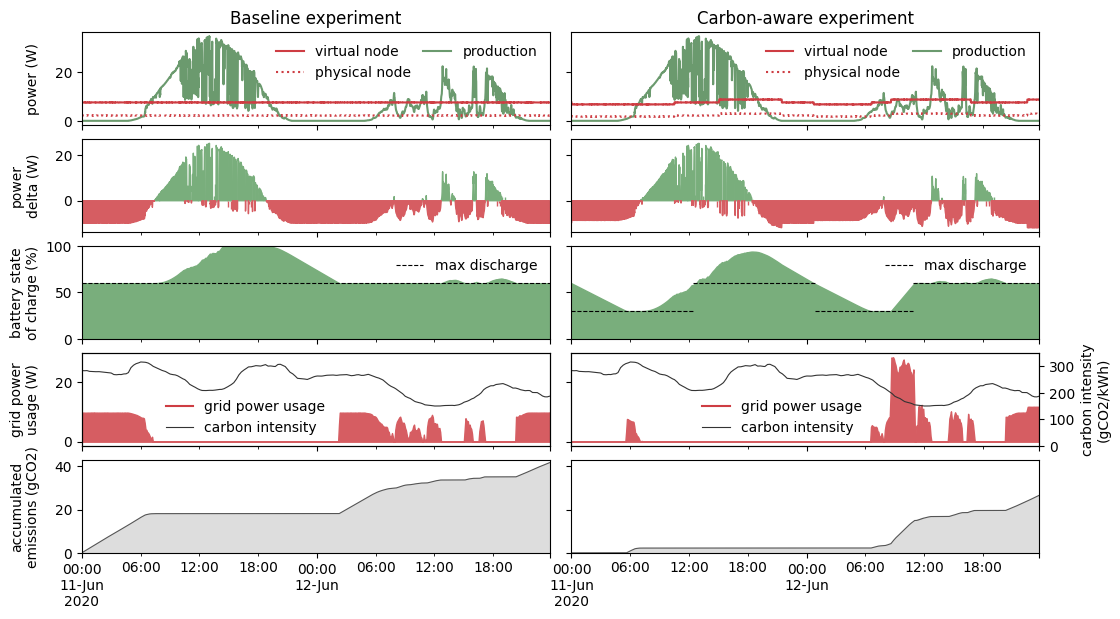

In [12]:
RED = "#D65D62"
BATTERY_COLOR = "#79ae7c"
GREEN = BATTERY_COLOR  # "#8BC34A"

def plot_evaluation(measurements_df, axs, title: str, left: bool):
    axs[0].set_title(title)

    measurements_df["production_power"].plot(ax=axs[0], color="#6b9a6e", label="production")
    measurements_df["raspi_power"].plot(ax=axs[0], color="#ce3d43", label="physical node", linestyle=":")
    measurements_df["aws_power"].plot(ax=axs[0], color="#ce3d43", label="virtual node")
    axs[0].set_ylabel("power (W)")
    h, l = axs[0].get_legend_handles_labels()
    axs[0].legend([h[2], h[1], h[0]], [l[2], l[1], l[0]], frameon=False, ncol=2, columnspacing=0.9)
    ü = h[2]

    x = measurements_df["delta_power"]
    x.plot(ax=axs[1], alpha=0)  # this call improves performance
    axs[1].fill_between(x.index, 0, x.values, where=x.values>0, color=GREEN)
    axs[1].fill_between(x.index, 0, x.values, where=x.values<0, color=RED)
    axs[1].set_ylabel("power\ndelta (W)")

    x = measurements_df["battery_soc"]
    x.plot(ax=axs[2], alpha=0)  # performance
    axs[2].fill_between(x.index, 0, x.values * 100, color=BATTERY_COLOR)
    axs[2].set_ylim(0, 100)
    axs[2].set_ylabel("battery state\nof charge (%)")
    if left:
        axs[2].axhline(60, linestyle="--", linewidth=.8, color="black", label="max discharge")
    else:
        X1 = .26
        X2 = .52
        X3 = .73
        axs[2].axhline(30, xmin=0, xmax=X1, linestyle="--", linewidth=.8, color="black", label="max discharge")
        axs[2].axhline(60, xmin=X1, xmax=X2, linestyle="--", linewidth=.8, color="black")
        axs[2].axhline(30, xmin=X2, xmax=X3, linestyle="--", linewidth=.8, color="black")
        axs[2].axhline(60, xmin=X3, xmax=1, linestyle="--", linewidth=.8, color="black")
        axs[2].axvline(X1, ymin=30, ymax=60, linestyle="--", linewidth=.8, color="black")
        axs[2].axvline(X2, ymin=30, ymax=60, linestyle="--", linewidth=.8, color="black")
        axs[2].axvline(X3, ymin=30, ymax=60, linestyle="--", linewidth=.8, color="black")

    h, l = axs[2].get_legend_handles_labels()
    axs[2].legend(h[1:], l[1:], frameon=False)

    grid = -measurements_df["excess_power"].groupby(pd.Grouper(freq='5min')).mean()
    grid[grid < 0] = 0
    grid.plot(ax=axs[3], alpha=0)  # performance
    axs[3].fill_between(grid.index, 0, grid.values, color=RED)
    axs[3].set_ylabel("grid power\nusage (W)")

    ax3_twin = axs[3].twinx()
    carbon.plot(ax=ax3_twin, color="#333", linewidth=.8)
    ax3_twin.set_ylim(0, 350)
    if not left:
        ax3_twin.set_ylabel("carbon intensity\n(gCO2/kWh)")
        ax3_twin.set_yticks([0, 100, 200, 300])
    else:
        ax3_twin.set_yticks([])

    h_, _ = ax3_twin.get_legend_handles_labels()
    if left:
        x = 0.35
    else:
        x = 0.45
    axs[3].legend([ü] + h_, ["grid power usage", "carbon intensity"], frameon=False, loc='upper center', bbox_to_anchor=(x, 0.63))

    grid = -measurements_df["excess_power"]
    grid[grid < 0] = 0
    emissions = grid * carbon  # 60 Ws * gCO2/kWh  //  gCO2/60000 // kgCO2/60000/1000
    emissions /= 60000
    emissions.cumsum().plot(ax=axs[4], color="#555", linewidth=.8)
    axs[4].fill_between(emissions.index, emissions.cumsum().values, color="#ddd")
    axs[4].set_ylabel("accumulated\nemissions (gCO2)")
    axs[4].set_ylim(0, 43)
    axs[4].set_xlabel("")
    #axs[4].set_xticks("2020")
    print(f"Carbon Emissions: {emissions.sum():.2f} gCO2; Grid energy: {grid.sum() * 60 / 3600:.2f} Wh")
    return emissions, grid

fig, axs = plt.subplots(ncols=2, nrows=5, sharex="col", sharey="row", figsize=(10,5.5))
fig.tight_layout(pad=0)
emissions1, grid1 = plot_evaluation(measurements_1, axs[:,0], title="Baseline experiment", left=True)
emissions2, grid2 = plot_evaluation(measurements_2, axs[:,1], title="Carbon-aware experiment", left=False)
fig.align_ylabels()

In [13]:
fig.savefig("../../Latex/2023-wiley-specialissue/ama/figures/evaluation.pdf", dpi=300, bbox_inches='tight')

In [14]:
print(1-(emissions2.sum()/emissions1.sum()))
print(1-(grid2.sum()/grid1.sum()))

0.3619729561274676
0.17789628091184573


In [15]:
second_night_start = "2020-06-12 00:00:00"
second_night_end = "2020-06-12 06:00:00"
grid1[second_night_start:second_night_end].sum() / 60, grid2[second_night_start:second_night_end].sum() / 60

(35.92938967512796, 0.0)

In [16]:
# Joule pro event
ö = BASE_LOAD / EVENTS_PER_SECOND
print(ö / ö)
print(BASE_LOAD_HIGH / EVENTS_PER_SECOND_HIGH / ö)
print(BASE_LOAD_LOW / EVENTS_PER_SECOND_LOW / ö)

ü = EVENTS_PER_SECOND / BASE_LOAD
print(ü)
print(EVENTS_PER_SECOND_HIGH / BASE_LOAD_HIGH)
print(EVENTS_PER_SECOND_LOW / BASE_LOAD_LOW)

1.0
1.0607407958625565
1.1182086938796076
999.5442114858706
942.3076923076923
893.8798427849523


In [20]:
# Joule pro event
ö = BASE_LOAD / EVENTS_PER_SECOND
print(ö / ö)
print(BASE_LOAD_HIGH / EVENTS_PER_SECOND_HIGH / ö)
print(BASE_LOAD_LOW / EVENTS_PER_SECOND_LOW / ö)

1.0
1.0607407958625565
1.1182086938796076


In [17]:
# Joule pro event
ö = BASE_LOAD_AWS / EVENTS_PER_SECOND_AWS
print(ö / ö)
print(BASE_LOAD_HIGH_AWS / EVENTS_PER_SECOND_HIGH_AWS / ö)
print(BASE_LOAD_LOW_AWS / EVENTS_PER_SECOND_LOW_AWS / ö)

1.0
0.8105263157894738
1.2526315789473685
